![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   



### И самое важное, все это вы сможете сделать самостоятельно!

*Этот Ноутбук являетсся Примером/Шаблоном к этому соревнованию (Baseline) и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.

> что такое baseline решение, зачем оно нужно и почему предоставлять baseline к соревнованию стало важным стандартом на kaggle и других площадках.   
**baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой, просто для примера. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline являеться хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

В контексте нашего соревнования baseline идет с небольшими примерами того, что можно делать с данными, и с инструкцией, что делать дальше, чтобы улучшить результат.  Вообще готовым решением это сложно назвать, так как используются всего 2 самых простых признака (а остальные исключаются).

# import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import re
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv
/kaggle/input/europe-cities-31/cities.csv
/kaggle/input/cities-31/cities.csv


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [4]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [5]:
# Подгружаю свой датасет с доп. данными по 31 городу
df_cities = pd.read_csv('/kaggle/input/cities-31/cities.csv')

In [ ]:
df_cities.info()

In [ ]:
df_train.info()

In [ ]:
df_train.head(5)

In [ ]:
df_test.info()

In [ ]:
df_test.head(5)

In [ ]:
sample_submission.head(5)

In [ ]:
sample_submission.info()

In [6]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [ ]:
data.info()

Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [ ]:
data.columns

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [7]:
# Добавляем столбец с информацией о пропусках в Number of Reviews
data['Number_of_Reviews_isNAN'] = pd.isna(data['Number of Reviews']).astype('uint8')

In [8]:
# Заполняю некоторые пропуски, большинство будет заполнено ниже
data['Cuisine Style'].fillna('Vegetarian Friendly', inplace=True) # самый часто повторяющийся вид кухни
data['Reviews'].fillna('', inplace=True)

In [ ]:
data.sample(2)

### 2. Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

In [ ]:
data.nunique(dropna=False)

Какие признаки можно считать категориальными?

Для кодирования категориальных признаков есть множество подходов:
* Label Encoding
* One-Hot Encoding
* Target Encoding
* Hashing

Выбор кодирования зависит от признака и выбраной модели.
Не будем сейчас сильно погружаться в эту тематику, давайте посмотрим лучше пример с One-Hot Encoding:
![](https://i.imgur.com/mtimFxh.png)

In [9]:
# для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
# One-Hot Encoding - 31 город из City
data = pd.concat([data,pd.get_dummies(data['City'])],axis=1)

In [ ]:
data.head(5)

In [ ]:
data.sample(5)

#### Возьмем следующий признак "Price Range".

По описанию 'Price Range' это - Цены в ресторане.  
Их можно поставить по возрастанию (значит это не категориальный признак). А это значит, что их можно заменить последовательными числами, например 1,2,3  
*Попробуйте сделать обработку этого признака уже самостоятельно!*

In [10]:
# Работа над признаком Price Range - прохожусь словарем по элементам 
# + заполняю пропуски 0
dict_price = {
    '$$$$': 3, 
    '$$ - $$$': 2, 
    '$': 1
    }
data['Price Range'] = data['Price Range'].map(dict_price) 
data['Price Range'].fillna(0, inplace=True) 

> Для некоторых алгоритмов МЛ даже для не категориальных признаков можно применить One-Hot Encoding, и это может улучшить качество модели. Пробуйте разные подходы к кодированию признака - никто не знает заранее, что может взлететь.

### Обработать другие признаки вы должны самостоятельно!
Для обработки других признаков вам возможно придется даже написать свою функцию, а может даже и не одну, но в этом и есть ваша практика в этом модуле!     
Следуя подсказкам в модуле вы сможете более подробно узнать, как сделать эти приобразования.

In [11]:
# Обработка признака Cuisine Style (чистка от скобок и прочих символов)
# и формирование нового признака cuisine_count - число кухонь в ресторане
cuisine_list = []
df_list = []
data['cuisine_count'] = 1
for i in range(len(data['Cuisine Style'])):
    if type(data['Cuisine Style'][i]) is str:
        for x, y in ("[", ""), ("]", ""), ("[[", ""), ("]]",""):
            data['Cuisine Style'][i] = data[
                'Cuisine Style'][i].replace(x, y)
        df_list = data['Cuisine Style'][i].split(', ')
        lenght_i = len(df_list)
        data['cuisine_count'][i] = lenght_i
        for j in range(len(data['Cuisine Style'][i].split("', '"))):
            cuisine_list.append(df_list[j].strip("'"))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [ ]:
# Ухудшает результаты работы модели! - не использую
# One-Hot обработка "своими руками" всех видов кухонь Cuisine_Style, 
# представленных во всех строках (125 кухонь)

# cuisine_set = set(cuisine_list) # list с кухнями преобразуем в set
# cuisine_list_set = list(cuisine_set) # вновь list для цикла
# for i in range(len(cuisine_set)):
#     data[cuisine_list_set[i]] = 0
# for i in range(len(data['Cuisine Style'])):
#     for j in range(len(cuisine_list_set)):
#         if cuisine_list_set[j] in data['Cuisine Style'][i]:
#             data[cuisine_list_set[j]][i] = 1

In [12]:
# Обработка признака Reviews с дальнейшей обработкой дат
# если значение отстутствует - отметка об этом в Reviews_isNAN
df_list_2 = []
data['date_1_review'] = 0 # дней от 1 отзыва до текущей даты
data['date_2_review'] = 0 # дней от 2 отзыва до текущей даты
data['date_review_diff'] = 0 # разница в днях между 2 отзывами
data['Reviews_isNAN'] = 0 # информация о пропущенных значениях
data['days_to_now'] = 0 # значение в днях до текущей даты
NOW = datetime.now() # текущее время
for i in range(len(data['Reviews'])):
    for x, y in ("[", ""), ("]", ""), ("[[", ""), ("]]",""):
        """Чистим Reviews от лишних символов, определяем vars"""
        data['Reviews'][i] = data['Reviews'][i].replace(x, y)
    df_list_2 = data['Reviews'][i].split("', '")
    for j in range(len(df_list_2)):
        df_list_2[j] = df_list_2[j].strip("'")
    if len(df_list_2) == 4: # проверка на 2 отзыва в Reviews
        dt1 = datetime.strptime(df_list_2[2], '%m/%d/%Y')
        dt2 = datetime.strptime(df_list_2[3], '%m/%d/%Y')
        diff = dt2 - dt1
        days_1 = abs((dt1 - NOW).days)
        days_2 = abs((dt2 - NOW).days)
        data['days_to_now'][i] = min(days_1, days_2)
        data['date_review_diff'][i] = abs(diff.days)
        data['date_1_review'][i] = days_1
        data['date_2_review'][i] = days_2
    if len(df_list_2) == 2: # проверка на только 1 отзыв в Reviews
        dt1 = datetime.strptime(df_list_2[1], '%m/%d/%Y')
        data['days_to_now'][i] = abs((dt1 - NOW).days)
        data['date_1_review'][i] = abs((dt1 - NOW).days)
    if len(data['Reviews'][i]) < 10: 
        # если строка короткая - значит необходимо отметить в isNAN
        data['Reviews_isNAN'][i] = 1

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value

In [13]:
# Работа со статистическими данными по городам
df_007 = pd.DataFrame() # новый датафрейм
df_007['Mean_Reviews_in_town'] = data.groupby('City')[
    'Number of Reviews'].mean() 
df_007['Count_Reviews_in_town'] = data.groupby('City')[
    'Number of Reviews'].sum() / 10000
df_007['Mean_date_diff_in_town'] = data.groupby('City')[
    'date_review_diff'].mean()
df_007['Count_rest_in_town'] = data.groupby('City')[
    'City'].count()
df_007['Mean_date_1_in_town'] = data.groupby('City')[
    'date_1_review'].mean()
df_007['Mean_date_2_in_town'] = data.groupby('City')[
    'date_2_review'].mean()
df_007['Mean_days_to_now'] = data.groupby('City')[
    'days_to_now'].mean()
df_007['Mean_Ranking_in_town'] = data.groupby('City')[
    'Ranking'].mean()
df_007['Sum_Ranking_in_town'] = data.groupby('City')[
    'Ranking'].sum()

In [14]:
# Объединяем датафреймы по столбцу City
data = data.merge(df_007, on='City', how='left')

In [15]:
# Заполняем остальные пропуски средними значениями признаков
for i in range(len(data['City'])):
    if pd.isna(data['Number of Reviews'][i]):
        data['Number of Reviews'][i] = data['Mean_Reviews_in_town'][i]
    if data['date_review_diff'][i] == 0:
        data['date_review_diff'][i] = data['Mean_date_diff_in_town'][i]
    if data['date_2_review'][i] == 0:
        data['date_2_review'][i] = data['Mean_date_2_in_town'][i]
    if data['date_1_review'][i] == 0:
        data['date_1_review'][i] = data['Mean_date_1_in_town'][i]
    if data['days_to_now'][i] == 0:
        data['days_to_now'][i] = data['Mean_days_to_now'][i]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher

In [16]:
# Объединяем датафрейм с новым датафреймом 
# с информацией о 31 городе из столбца City
data = data.merge(df_cities, on='City', how='left')

In [17]:
# Формируем новые признаки на основе имеющихся
# Физический смысл многих отсутствует
data['Rank_in_town_new'] = data['Count_rest_in_town'] / data['Ranking']
data['Mean_Rank_Count_rest'] = (data['Mean_Ranking_in_town']/
                                data['Count_rest_in_town'])
data['Mean_Rank_to_Rank'] = (data['Mean_Ranking_in_town']/
                             data['Ranking'])
data['Otnosit_Rank_town'] = ((data['Count_rest_in_town'] -
                             data['Ranking'])/
                            data['Count_rest_in_town'] - 1)
data['Otnosit_Rank_to_mean'] = ((data['Mean_Ranking_in_town'] -
                                 data['Ranking'])/
                                data['Mean_Ranking_in_town'])
data['Otnosit_Reviews_to_mean'] = ((data['Number of Reviews'] -
                                    data['Mean_Reviews_in_town'])/
                                   data['Mean_Reviews_in_town'])
data['Sum_Ranking_in_town'] = data['Sum_Ranking_in_town'] / 10000000
data['new_1'] = data['Плотность населения'] / data['Otnosit_Rank_town'] 
data['new_2'] = data['Otnosit_Rank_town'] * data['Number of Reviews'] 
data['new_3'] = data['Otnosit_Rank_to_mean'] * data['Number of Reviews'] 
data['new_4'] = data['Number of Reviews'] / data['Ranking']

In [18]:
# Убираем снижающие эффективность модели признаки
data.drop(['Mean_date_1_in_town'], axis = 1, inplace=True)
data.drop(['Mean_Reviews_in_town'], axis = 1, inplace=True)
data.drop(['Restaurant_id','ID_TA'], axis = 1, inplace=True)
data.drop(['Площадь'], axis = 1, inplace=True)

In [ ]:
data.columns

In [ ]:
data.sample(10)

![](https://cs10.pikabu.ru/post_img/2018/09/06/11/1536261023140110012.jpg)

# EDA 
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.
![](https://miro.medium.com/max/2598/1*RXdMb7Uk6mGqWqPguHULaQ.png)

### Посмотрим распределение признака

# Визуализировать будем новый датафрейм - тренировочная часть с учетом новых признаков

In [19]:
df_train_new = data.query('sample == 1')

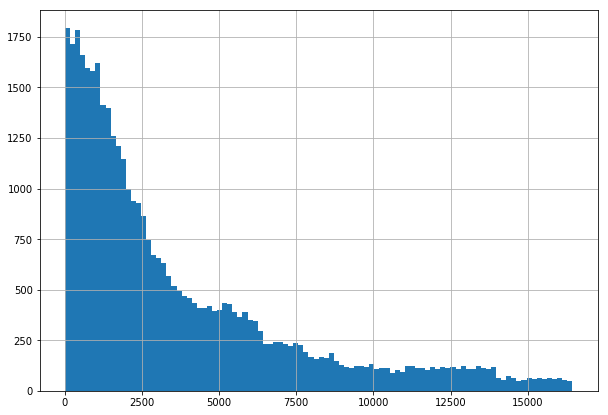

In [20]:
plt.rcParams['figure.figsize'] = (10,7)
df_train_new['Ranking'].hist(bins=100);

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

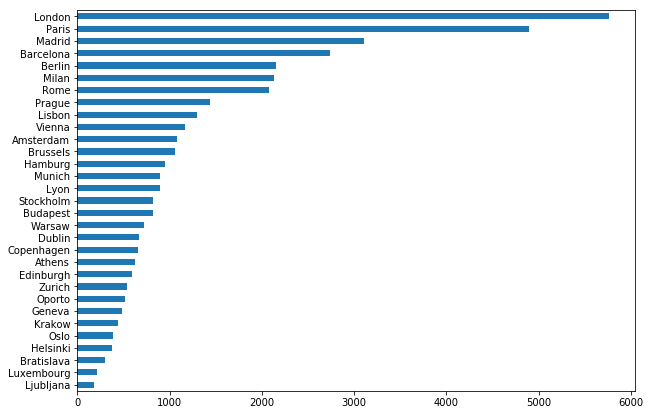

In [21]:
df_train_new['City'].value_counts(ascending=True).plot(kind='barh');

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

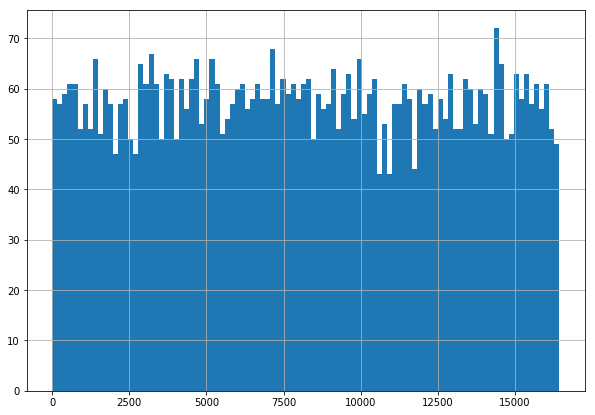

In [22]:
df_train_new['Ranking'][df_train_new['City'] =='London'].hist(bins=100);

Проанализируем введенные новые признаки (Mean_Rank_to_Rank - средний ранк в городе к ранку ресторана)

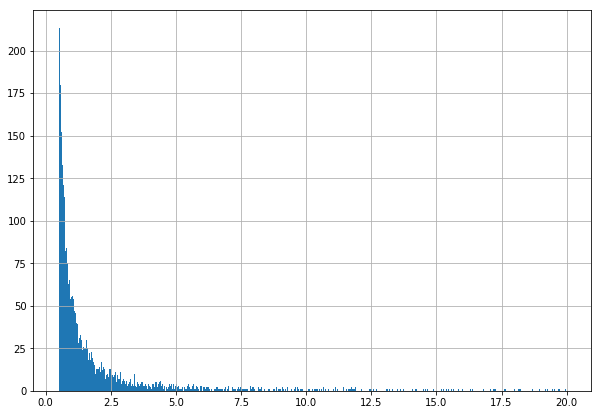

In [23]:
df_train_new.query('City == "London" & Mean_Rank_to_Rank < 20')['Mean_Rank_to_Rank'].hist(bins=1000);

In [ ]:
# Создаем датафрейм для визуализации с учетом np.log() от признак
df_visual = df_train_new.copy()

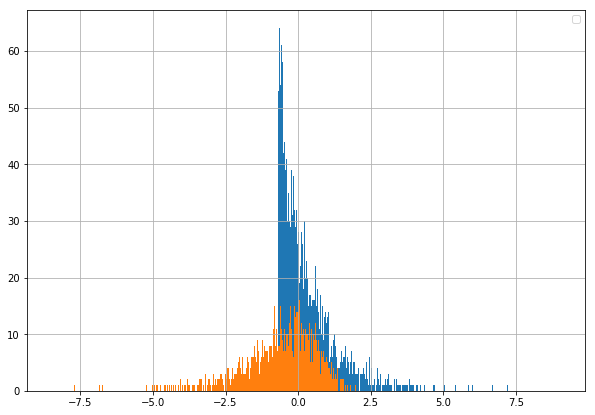

In [41]:
# По виду распределения кажется, что оно логарифмически нормальное 
df_visual['Mean_Rank_to_Rank'] = np.log(df_train_new['Mean_Rank_to_Rank'])
log_1 = df_visual.query(
                'City == "London" & Mean_Rank_to_Rank < 20'
                )['Mean_Rank_to_Rank'].hist(bins=1000);
# Возьмем еще раз логарифм - тогда распределение становится нормальным
df_visual['Mean_Rank_to_Rank'] = np.log(df_visual['Mean_Rank_to_Rank'])
log_2 = df_visual.query(
                'City == "London" & Mean_Rank_to_Rank < 20'
                )['Mean_Rank_to_Rank'].hist(bins=1000);

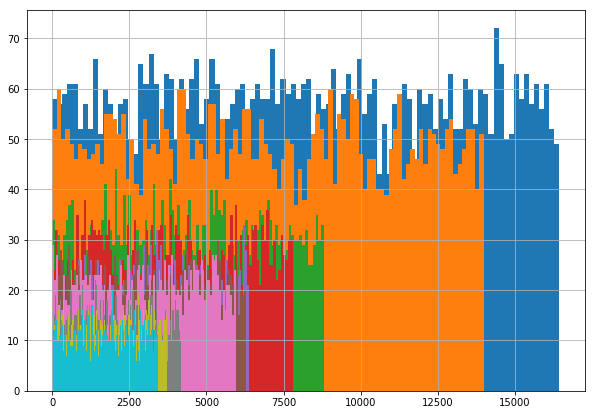

In [42]:
# посмотрим на топ 10 городов
for x in (df_train_new['City'].value_counts())[0:10].index:
    df_train_new['Ranking'][df_train_new['City'] == x].hist(bins=100);
plt.show()

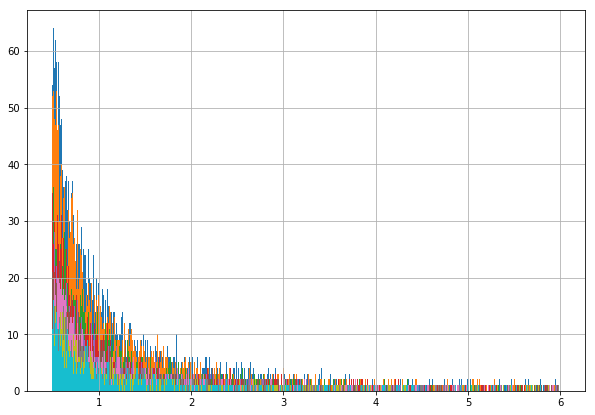

In [43]:
# посмотрим на топ 10 городов
for x in (df_train_new['City'].value_counts())[0:10].index:
    df_train_new['Mean_Rank_to_Rank'][(df_train_new['City'] == x) & (df_train_new['Mean_Rank_to_Rank'] < 6)].hist(bins=1000);
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

>Подумайте как из этого можно сделать признак для вашей модели. Я покажу вам пример, как визуализация помогает находить взаимосвязи. А далее действуйте без подсказок =) 


## Вывод - значит, что относительные величины, которые увязывают значение Ранка со средним значением ранка в городе и другие, распределены нормально (при взятии 2 раз логарифма от признака) и дают более объективную связь. Таким образом, ввод в модель признаков относительных оценок позволяет нормировать взаимосвязь между Ранком в соответствии с городом, вне зависимости от того, сколько ресторанов представлено в городе в изначальном датафрейме.

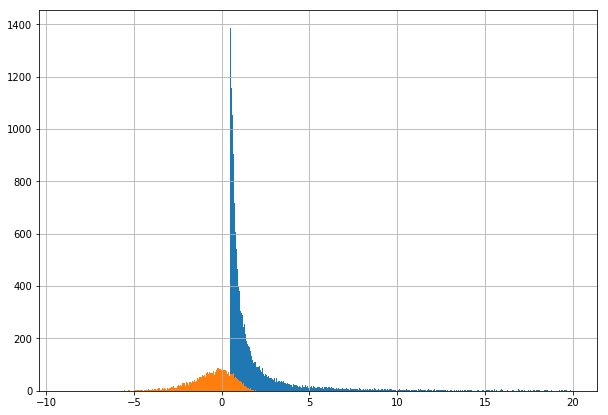

In [47]:
# df_vusial имеет признак Mean_Rank_to_Rank с учетом взятия 
# 2 раз логарифма
df_train_new.query('Mean_Rank_to_Rank < 20')['Mean_Rank_to_Rank'].hist(bins=1000);
df_visual.query('Mean_Rank_to_Rank < 20')['Mean_Rank_to_Rank'].hist(bins=1000);

### Посмотрим распределение целевой переменной

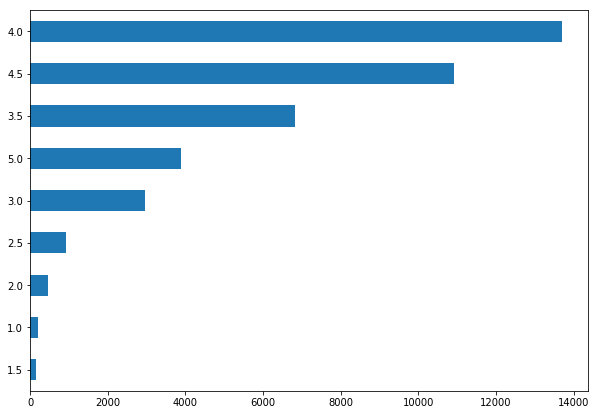

In [48]:
df_train_new['Rating'].value_counts(ascending=True).plot(kind='barh');

### Посмотрим распределение целевой переменной относительно признака

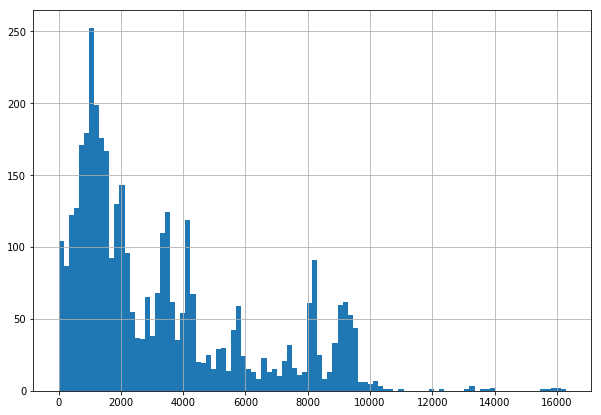

In [49]:
df_train_new['Ranking'][df_train_new['Rating'] == 5].hist(bins=100);

8169.707354372306

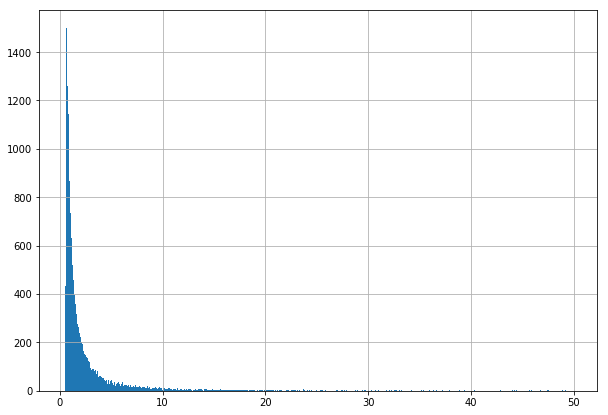

In [52]:
df_train_new.query('Rating >= 4 & Mean_Rank_to_Rank < 50')['Mean_Rank_to_Rank'].hist(bins=1000);
df_train_new.query('Rating >= 4')['Mean_Rank_to_Rank'].max()

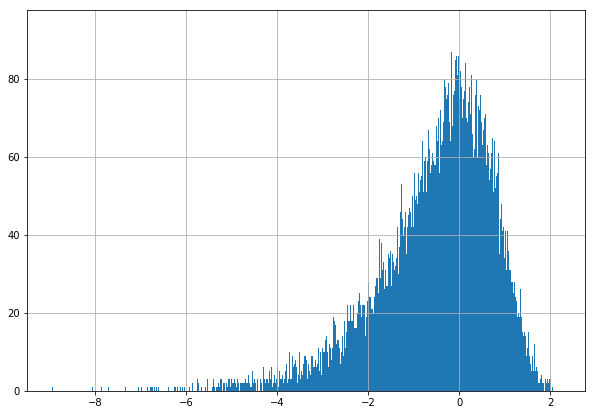

In [60]:
# С учетом взятия 2 раз логарифма от 'Mean_Rank_to_Rank'
df_visual.query('Rating >= 4 & Mean_Rank_to_Rank < 50')['Mean_Rank_to_Rank'].hist(bins=1000);

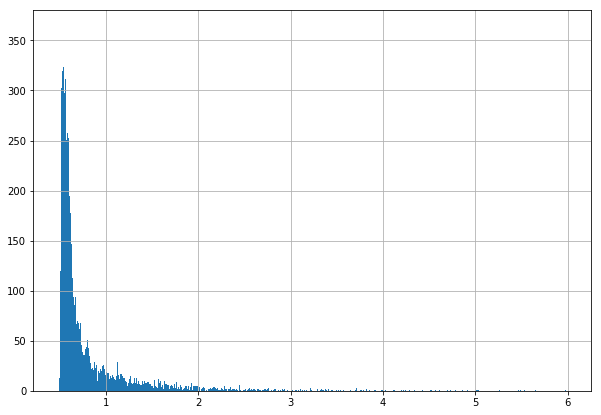

In [62]:
df_train_new.query('2 < Rating <= 3.5 & Mean_Rank_to_Rank < 6')['Mean_Rank_to_Rank'].hist(bins=1000);

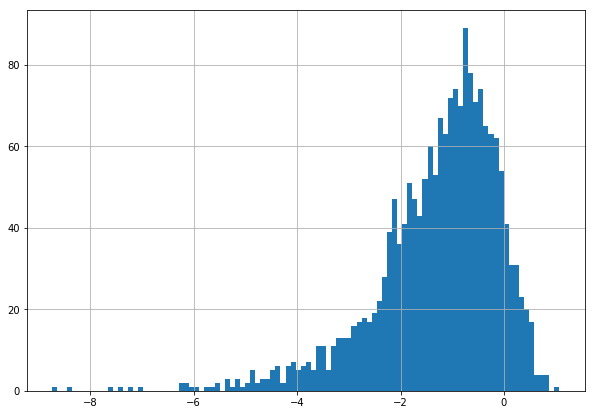

In [66]:
# С учетом взятия 2 раз логарифма от 'Mean_Rank_to_Rank'
df_visual.query('2 < Rating <= 3.5 & Mean_Rank_to_Rank < 6')['Mean_Rank_to_Rank'].hist(bins=100);

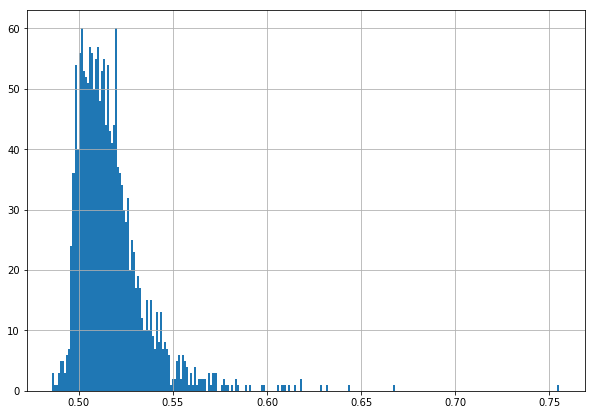

In [58]:
df_train_new.query('0 < Rating <= 2.5')['Mean_Rank_to_Rank'].hist(bins=250);

## Вывод по результатам анализа значения величины Mean_Rank_to_Rank: При низком рейтинге ресторана (например, от 3 и ниже) значение величины находится в пределах от 0.5 до 2. Чем выше рейтинг ресторана, следовательно ниже его Ранк, следовательно данная относительная оценка - становится все больше (например, при рейтинге от 4 и выше - доходит до нескольких тысяч (max - 8169).

Сам по себе показатель Ranking - довольно не информативный показатель. Однако, при наличии его в модели результаты МАЕ ниже, чем при его отсутствии. Все-таки, для физической интерпретации и понимания гораздо полезнее оперировать относительными или средними оценками. Они добавлены в достаточном количестве (полагаю, даже в излишнем, но все равно они повышают результат МАЕ).

С учетом взятия 2 раз логарифма от величины Mean_Rank_to_Rank - распределение становится похожим на нормальное.

## Аналогично Ранку рассмотрим распределение числа отзывов и относительной величины

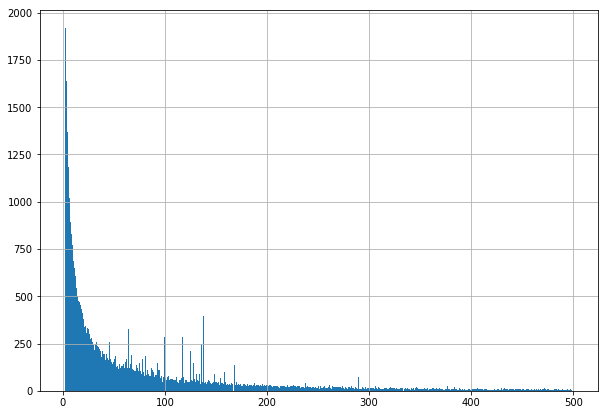

In [71]:
df_train_new['Number of Reviews'][df_train_new['Number of Reviews'] < 500].hist(bins=500);

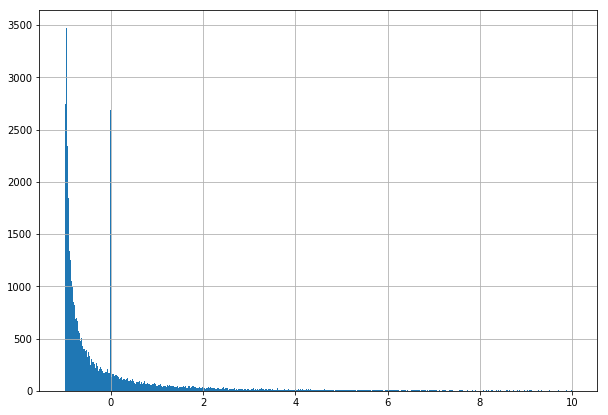

In [72]:
df_train_new['Otnosit_Reviews_to_mean'][df_train_new['Otnosit_Reviews_to_mean'] < 10].hist(bins=500);

Общий вид распределения "Number of Reviews" и "Otnosit_Reviews_to_mean" одинаковый, единственное - что значения в относительном варианте колеблются в меньшем диапазоне, что, по-моему мнению, положительно влияет на вычислительную точность модели и результате МАЕ. Аналогично по городам.

### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

In [ ]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),);

# На представленной таблице корреляции (тепловой карте) видны несколько обратнопропорциональных признаков в правой нижней части (черные клетки). Однако, при проведении экспериментов по чистке взаимозависимых признаков из модели выяснилось, что вычленение данных признаков из модели - увеличивает абсолютную ошибку МАЕ. Кроме того, насколько полагаю, в задаче, которая не является задачей линейной регрессии, сильно скоррелированные признаки не оказывают сильного пагубного воздействия на результаты.

Вообще благодаря визуализации в этом датасете можно узнать много интересных фактов, например:
* где больше Пицерий в Мадриде или Лондоне?
* в каком городе кухня ресторанов более разнообразна?

придумайте свои вопрос и найдите на него ответ в данных)

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [73]:
# на всякий случай, заново подгружаем данные
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
df_cities = pd.read_csv('/kaggle/input/cities-31/cities.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [74]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # Добавляем столбец с информацией о пропусках в Number of Reviews
    df_output['Number_of_Reviews_isNAN'] = pd.isna(
        df_output['Number of Reviews']).astype('uint8')
    
    # Заполняю некоторые пропуски, большинство будет заполнено ниже
    df_output['Cuisine Style'].fillna('Vegetarian Friendly', inplace=True) 
    df_output['Reviews'].fillna('', inplace=True)
    
    # One-Hot Encoding - 31 город из City
    df_output = pd.concat([df_output,pd.get_dummies(df_output['City'])],axis=1)
    
    # Работа над признаком Price Range - прохожусь словарем по элементам 
    # + заполняю пропуски 0
    dict_price = {
        '$$$$': 3, 
        '$$ - $$$': 2, 
        '$': 1
        }
    df_output['Price Range'] = df_output['Price Range'].map(dict_price) 
    df_output['Price Range'].fillna(0, inplace=True) 
    
    # Обработка признака Cuisine Style (чистка от скобок и прочих символов)
    # и формирование нового признака cuisine_count - число кухонь в ресторане
    cuisine_list = []
    df_list = []
    df_output['cuisine_count'] = 1
    for i in range(len(df_output['Cuisine Style'])):
        if type(df_output['Cuisine Style'][i]) is str:
            for x, y in ("[", ""), ("]", ""), ("[[", ""), ("]]",""):
                df_output['Cuisine Style'][i] = df_output[
                    'Cuisine Style'][i].replace(x, y)
            df_list = df_output['Cuisine Style'][i].split(', ')
            lenght_i = len(df_list)
            df_output['cuisine_count'][i] = lenght_i
            for j in range(len(df_output['Cuisine Style'][i].split("', '"))):
                cuisine_list.append(df_list[j].strip("'"))
    
    
    # Обработка признака Reviews с дальнейшей обработкой дат
    # если значение отстутствует - отметка об этом в Reviews_isNAN
    df_list_2 = []
    df_output['date_1_review'] = 0 # дней от 1 отзыва до текущей даты
    df_output['date_2_review'] = 0 # дней от 2 отзыва до текущей даты
    df_output['date_review_diff'] = 0 # разница в днях между 2 отзывами
    df_output['Reviews_isNAN'] = 0 # информация о пропущенных значениях
    df_output['days_to_now'] = 0 # значение в днях до текущей даты
    NOW = datetime.now() # текущее время
    for i in range(len(df_output['Reviews'])):
        for x, y in ("[", ""), ("]", ""), ("[[", ""), ("]]",""):
            """Чистим Reviews от лишних символов, определяем vars"""
            df_output['Reviews'][i] = df_output['Reviews'][i].replace(x, y)
        df_list_2 = df_output['Reviews'][i].split("', '")
        for j in range(len(df_list_2)):
            df_list_2[j] = df_list_2[j].strip("'")
        if len(df_list_2) == 4: # проверка на 2 отзыва в Reviews
            dt1 = datetime.strptime(df_list_2[2], '%m/%d/%Y')
            dt2 = datetime.strptime(df_list_2[3], '%m/%d/%Y')
            diff = dt2 - dt1
            days_1 = abs((dt1 - NOW).days)
            days_2 = abs((dt2 - NOW).days)
            df_output['days_to_now'][i] = min(days_1, days_2)
            df_output['date_review_diff'][i] = abs(diff.days)
            df_output['date_1_review'][i] = days_1
            df_output['date_2_review'][i] = days_2
        if len(df_list_2) == 2: # проверка на только 1 отзыв в Reviews
            dt1 = datetime.strptime(df_list_2[1], '%m/%d/%Y')
            df_output['days_to_now'][i] = abs((dt1 - NOW).days)
            df_output['date_1_review'][i] = abs((dt1 - NOW).days)
        if len(df_output['Reviews'][i]) < 10: 
        # если строка короткая - значит необходимо отметить в isNAN
            df_output['Reviews_isNAN'][i] = 1
    
    # Работа со статистическими данными по городам
    df_007 = pd.DataFrame() # новый датафрейм
    df_007['Mean_Reviews_in_town'] = df_output.groupby('City')[
        'Number of Reviews'].mean() 
    df_007['Count_Reviews_in_town'] = df_output.groupby('City')[
        'Number of Reviews'].sum() / 10000
    df_007['Mean_date_diff_in_town'] = df_output.groupby('City')[
        'date_review_diff'].mean()
    df_007['Count_rest_in_town'] = df_output.groupby('City')[
        'City'].count()
    df_007['Mean_date_1_in_town'] = df_output.groupby('City')[
        'date_1_review'].mean()
    df_007['Mean_date_2_in_town'] = df_output.groupby('City')[
        'date_2_review'].mean()
    df_007['Mean_days_to_now'] = df_output.groupby('City')[
        'days_to_now'].mean()
    df_007['Mean_Ranking_in_town'] = df_output.groupby('City')[
        'Ranking'].mean()
    df_007['Sum_Ranking_in_town'] = df_output.groupby('City')[
        'Ranking'].sum()
    
    # Объединяем датафреймы по столбцу City
    df_output = df_output.merge(df_007, on='City', how='left')
    
    # Заполняем остальные пропуски средними значениями признаков
    for i in range(len(df_output['City'])):
        if pd.isna(df_output['Number of Reviews'][i]):
            df_output['Number of Reviews'][i] = \
            df_output['Mean_Reviews_in_town'][i]
        if df_output['date_review_diff'][i] == 0:
            df_output['date_review_diff'][i] = \
            df_output['Mean_date_diff_in_town'][i]
        if df_output['date_2_review'][i] == 0:
            df_output['date_2_review'][i] = \
            df_output['Mean_date_2_in_town'][i]
        if df_output['date_1_review'][i] == 0:
            df_output['date_1_review'][i] = \
            df_output['Mean_date_1_in_town'][i]
        if df_output['days_to_now'][i] == 0:
            df_output['days_to_now'][i] = \
            df_output['Mean_days_to_now'][i]
    
    # Объединяем датафрейм с новым датафреймом 
    # с информацией о 31 городе из столбца City
    df_output = df_output.merge(df_cities, on='City', how='left')
    
    # Формируем новые признаки на основе имеющихся
    # Физический смысл многих отсутствует
    df_output['Rank_in_town_new'] = \
        df_output['Count_rest_in_town'] / \
        df_output['Ranking']
    df_output['Mean_Rank_Count_rest'] = \
        df_output['Mean_Ranking_in_town'] / \
        df_output['Count_rest_in_town']
    df_output['Mean_Rank_to_Rank'] = \
        df_output['Mean_Ranking_in_town'] / df_output['Ranking']
    df_output['Otnosit_Rank_town'] = (
        (df_output['Count_rest_in_town'] - \
         df_output['Ranking']) / \
        df_output['Count_rest_in_town'] - 1)
    df_output['Otnosit_Rank_to_mean'] = (
        (df_output['Mean_Ranking_in_town'] - \
         df_output['Ranking']) / \
        df_output['Mean_Ranking_in_town'])
    df_output['Otnosit_Reviews_to_mean'] = (
        (df_output['Number of Reviews'] - \
         df_output['Mean_Reviews_in_town']) / \
        df_output['Mean_Reviews_in_town'])
    df_output['Sum_Ranking_in_town'] = \
        df_output['Sum_Ranking_in_town'] / 10000000
    df_output['new_1'] = df_output['Плотность населения'] / \
                         df_output['Otnosit_Rank_town'] 
    df_output['new_2'] = df_output['Otnosit_Rank_town'] * \
                         df_output['Number of Reviews'] 
    df_output['new_3'] = df_output['Otnosit_Rank_to_mean'] * \
                         df_output['Number of Reviews'] 
    df_output['new_4'] = df_output['Number of Reviews'] / \
                         df_output['Ranking']
    
    # Убираем снижающие эффективность модели признаки
    df_output.drop(['Mean_date_1_in_town'], axis = 1, inplace=True)
    df_output.drop(['Mean_Reviews_in_town'], axis = 1, inplace=True)
    df_output.drop(['Restaurant_id','ID_TA'], axis = 1, inplace=True)
    df_output.drop(['Площадь'], axis = 1, inplace=True)
    
    
    # ################### 1. Предобработка ###################################
    # убираем не нужные для модели признаки
    
    # ################### 2. NAN ###################################################
    # Далее заполняем пропуски, 
    
    # ################### 3. Encoding ##############################################
    # для One-Hot Encoding в pandas есть готовая функция - get_dummies. 
    # Особенно радует параметр dummy_na
    # df_output = pd.get_dummies(df_output, columns=[ 'City',], dummy_na=True)
   
    # ################### 4. Feature Engineering ###################################
    # тут ваш код не генерацию новых фитчей
    
    # ################### 5. Clean ###################################################
    # убираем признаки которые еще не успели обработать, 
    # модель на признаках с dtypes "object" обучаться не будет, просто их удалим
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis = 1, inplace=True)
    
    return df_output

>По хорошему, можно было бы перевести эту большую функцию в класс и разбить на подфункции (согласно ООП). 

#### Запускаем и проверяем что получилось

In [75]:
df_preproc = preproc_data(data)
df_preproc.sample(10)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be s

,Ranking,Price Range,Number of Reviews,sample,Rating,Number_of_Reviews_isNAN,Amsterdam,Athens,Barcelona,Berlin,...,Rank_in_town_new,Mean_Rank_Count_rest,Mean_Rank_to_Rank,Otnosit_Rank_town,Otnosit_Rank_to_mean,Otnosit_Reviews_to_mean,new_1,new_2,new_3,new_4
24287,1958.0,1.0,14.000000,1,4.5,0,0,0,0,0,...,0.736977,1.185915,0.873992,-1.356895,-0.144176,-0.826163,-33.696537,-18.996535,-2.018458,0.007150
30303,2981.0,2.0,378.000000,1,4.0,0,0,0,0,0,...,2.412949,1.135786,2.740593,-0.414431,0.635115,1.739758,-137.562465,-156.654803,240.073640,0.126803
31654,1670.0,1.0,70.000000,1,2.5,0,0,0,0,0,...,0.446108,1.188094,0.530018,-2.241611,-0.886728,-0.705525,-18.452984,-156.912752,-62.070965,0.041916
24747,1413.0,1.0,20.000000,1,4.0,0,0,0,0,0,...,1.021231,1.185915,1.211094,-0.979210,0.174300,-0.751661,-46.693432,-19.584200,3.486005,0.014154
8641,1923.0,2.0,169.000000,0,0.0,0,0,0,0,0,...,0.425897,1.199204,0.510737,-2.347985,-0.957954,0.777861,-30.505767,-396.809524,-161.894209,0.087884
30957,2126.0,2.0,107.000000,1,3.5,0,0,0,0,1,...,1.272342,1.203482,1.531241,-0.785952,0.346935,0.677847,-51.989538,-84.096858,37.122025,0.050329
42904,4639.0,1.0,11.000000,1,4.5,0,0,0,0,0,...,0.558094,1.147444,0.640382,-1.791812,-0.561567,-0.962041,-12.447630,-19.709927,-6.177242,0.002371
15225,1245.0,0.0,10.000000,1,4.5,0,0,0,0,0,...,0.904418,1.157995,1.047311,-1.105684,0.045174,-0.885154,-95.456575,-11.056838,0.451739,0.008032
44804,1300.0,1.0,14.000000,1,4.5,0,0,0,0,1,...,2.080769,1.203482,2.504167,-0.480591,0.600666,-0.780469,-85.022890,-6.728281,8.409320,0.010769
12293,2027.0,0.0,127.830078,1,5.0,1,0,0,0,0,...,0.812531,1.133777,0.921229,-1.230723,-0.085507,0.000000,-41.075546,-157.323357,-10.930359,0.063064


In [76]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 65 columns):
Ranking                    50000 non-null float64
Price Range                50000 non-null float64
Number of Reviews          50000 non-null float64
sample                     50000 non-null int64
Rating                     50000 non-null float64
Number_of_Reviews_isNAN    50000 non-null uint8
Amsterdam                  50000 non-null uint8
Athens                     50000 non-null uint8
Barcelona                  50000 non-null uint8
Berlin                     50000 non-null uint8
Bratislava                 50000 non-null uint8
Brussels                   50000 non-null uint8
Budapest                   50000 non-null uint8
Copenhagen                 50000 non-null uint8
Dublin                     50000 non-null uint8
Edinburgh                  50000 non-null uint8
Geneva                     50000 non-null uint8
Hamburg                    50000 non-null uint8
Helsinki           

In [77]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [78]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [79]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 64), (40000, 64), (40000, 63), (32000, 63), (8000, 63))

# Model 
Сам ML

In [80]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [81]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [82]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   25.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [83]:
def rating(prediction):
    if prediction <= 0.25:
        return 0
    elif 0.25 < prediction <= 0.75:
        return 0.5
    elif 0.75 < prediction <= 1.25:
        return 1
    elif 1.25 < prediction <= 1.75:
        return 1.5
    elif 1.75 < prediction <= 2.25:
        return 2
    elif 2.25 < prediction <= 2.75:
        return 2.5
    elif 2.75 < prediction <= 3.25:
        return 3
    elif 3.25 < prediction <= 3.75:
        return 3.5
    elif 3.75 < prediction <= 4.25:
        return 4
    elif 4.25 < prediction <= 4.75:
        return 4.5
    else:
        return 5

In [84]:
for i in range(len(y_pred)):
    y_pred[i] = rating(y_pred[i])

In [85]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.1665625


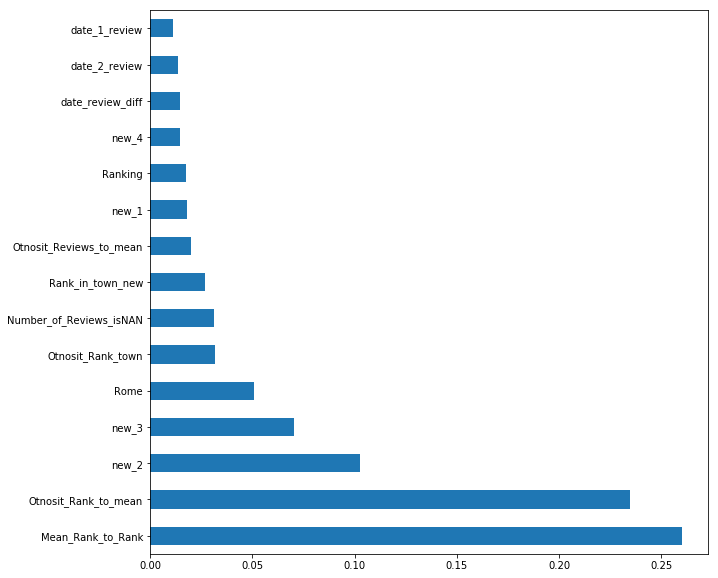

In [86]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [87]:
test_data.sample(10)

,Ranking,Price Range,Number of Reviews,Rating,Number_of_Reviews_isNAN,Amsterdam,Athens,Barcelona,Berlin,Bratislava,...,Rank_in_town_new,Mean_Rank_Count_rest,Mean_Rank_to_Rank,Otnosit_Rank_town,Otnosit_Rank_to_mean,Otnosit_Reviews_to_mean,new_1,new_2,new_3,new_4
1518,1707.0,2.0,45.000000,0.0,0,0,0,0,0,0,...,0.489748,1.162833,0.569495,-2.041866,-0.755942,-0.708316,-18.067993,-91.883971,-34.017373,0.026362
9465,425.0,3.0,115.000000,0.0,0,0,0,0,0,0,...,1.611765,1.159533,1.868895,-0.620438,0.464924,0.585986,-75.111214,-71.350365,53.466307,0.270588
9672,1000.0,2.0,48.000000,0.0,0,0,0,0,0,0,...,1.647000,1.133777,1.867330,-0.607165,0.464476,-0.624502,-83.260132,-29.143898,22.294853,0.048000
4932,14325.0,0.0,6.000000,0.0,0,0,0,0,0,0,...,0.502129,1.135786,0.570311,-1.991520,-0.753429,-0.956512,-28.626437,-11.949117,-4.520573,0.000419
8906,1550.0,2.0,77.649387,0.0,1,0,0,0,0,0,...,0.738710,1.196767,0.884063,-1.353712,-0.131141,0.000000,-34.952322,-105.114891,-10.183016,0.050096
7138,3843.0,1.0,26.000000,0.0,0,0,0,1,0,0,...,0.883424,1.142687,1.009478,-1.131959,0.009389,-0.808377,-145.562277,-29.430928,0.244106,0.006766
875,3646.0,2.0,12.000000,0.0,0,0,0,0,1,0,...,0.741909,1.203482,0.892874,-1.347874,-0.119979,-0.811830,-30.315348,-16.174492,-1.439750,0.003291
5511,3459.0,0.0,30.000000,0.0,0,0,0,0,0,0,...,1.765828,1.135979,2.005943,-0.566306,0.501481,-0.743679,-361.293006,-16.989194,15.044441,0.008673
8407,5976.0,0.0,11.000000,0.0,0,0,0,1,0,0,...,0.568106,1.142687,0.649167,-1.760236,-0.540435,-0.918929,-93.607067,-19.362592,-5.944789,0.001841
3010,11437.0,2.0,43.000000,0.0,0,0,0,0,0,0,...,0.534056,1.135979,0.606676,-1.872462,-0.648325,-0.632607,-109.269258,-80.515881,-27.877992,0.003760


In [88]:
test_data = test_data.drop(['Rating'], axis=1)

In [89]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [90]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [91]:
predict_submission

array([3.1  , 4.255, 4.385, ..., 3.   , 4.46 , 4.395])

In [92]:
for i in range(len(predict_submission)):
    predict_submission[i] = rating(predict_submission[i])

In [93]:
predict_submission

array([3. , 4.5, 4.5, ..., 3. , 4.5, 4.5])

In [94]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.5
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,2.0
7,id_7,2.5
8,id_8,4.5
9,id_9,4.5


In [95]:
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.5
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,2.0
7,id_7,2.5
8,id_8,4.5
9,id_9,4.5


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
